In [63]:
#importamos librerias necesarias para la manipulación
import pandas as pd
import numpy as np

In [16]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
#%pip uninstall -y tensorflow --quiet
%pip install ludwig --quiet
%pip install ludwig[viz] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 29.3 MB/s eta 0:00:00
  

In [ ]:
#Cargamos base de datos en formato CSV
#Cargamos base de datos en formato CSV
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/negativa_positiva - Hoja 1.csv')

In [ ]:
df

,TITULO,DESCRIPCION,CATEGORIA,DUMMY
0,¡Preocupante! Ocupación hotelera en Colombia s...,De acuerdo con el Sistema de Información Hotel...,NEGATIVA,-1
1,Dumek: “No puedo decir que a Cartagena la saqu...,"Dumek Turbay, que resultó siendo el gran vence...",NEGATIVA,-1
2,Reportan baja de operaciones en 4 de las 10 ru...,"De enero a septiembre de este año, cuatro de l...",NEGATIVA,-1
3,BM advierte que pagos de la deuda privan de di...,"Brasil, Argentina, México, Colombia y Ecuador ...",NEGATIVA,-1
4,La Cumbre del Clima podría promover la expansi...,El documento final de la COP28 en Dubái da pie...,NEGATIVA,-1
...,...,...,...,...
410,Los costos están impulsando cambios en los háb...,El turismo en Colombia está en alza a nivel in...,POSITIVA,1
411,La nueva aerolínea que solicitó operar en Colo...,"\r\nUna nueva aerolínea, ALMA, solicita operar...",POSITIVA,1
412,Nuestra meta es llegar a todos los rincones tu...,"Civitatis, plataforma de actividades turística...",POSITIVA,1
413,Dan detalles del plan para reactivar la econom...,El presidente Gustavo Petro anunció la prepara...,POSITIVA,1


In [ ]:
# Para contar cuántas veces aparece cada valor en la columna CATEGORIA
conteo = df['CATEGORIA'].value_counts()

print(conteo)

CATEGORIA
POSITIVA    271
NEGATIVA    144
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Guardar los conjuntos de datos
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

In [ ]:
#Token Hugging face acceso
import getpass
#import locale; locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import logging
import os

#from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


In [ ]:
import logging
from ludwig.api import LudwigModel

# Configuración ajustada
config = {
    "input_features": [
        {
            "name": "DESCRIPCION ",
            "type": "text",
            "preprocessing": {"tokenizer":"hf_tokenizer", "cache_encoder_embeddings": True},
            "encoder": {
                "type": "auto_transformer",
                "pretrained_model_name_or_path": "distilbert/distilbert-base-multilingual-cased",
                 "trainable": True,
                "regularizer": {
                    "type": "l2",
                    "weight": 0.001  # Regularización L2 aplicada al encoder
                }
            }
        },
    ],
    "output_features": [
        {
            "name": "CATEGORIA",
            "type": "binary",
            "calibration": True
        }
    ],
    "preprocessing": {
        "oversample_minority": 0.5
    },
    "adapter": {  # Corregido el espacio adicional en el nombre de la clave
        "type": "lora",
        "r": 8,
        "dropout": 0.05,
        "target_modules": None,  # Corregido de Null a None
        "use_rslora": False,
        "use_dora": False,
        "alpha": 16,
        "pretrained_adapter_weights": None,  # Corregido de Null a None
        "postprocessor": {
            "merge_adapter_into_base_model": False,
            "progressbar": False,
            "bias_type": "none"  # Corregido para que el valor sea una cadena
        }
    },
    "trainer": {
        "epochs": 60,
        "learning_rate": 0.0001,
        "optimizer": {"type": "adamw"},
        "batch_size": 32,
        "early_stop": 30,
    }
}

In [ ]:
# Crea una instancia del modelo Ludwig con la configuración
model = LudwigModel(config, logging_level=logging.INFO)

In [ ]:
train_stats,pred,out = model.train(dataset=train_df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

INFO:ludwig.utils.tokenizers:Loaded TorchText implementation of distilbert/distilbert-base-multilingual-cased tokenizer
INFO:ludwig.features.text_feature:Max length of feature 'DESCRIPCION ': 295 (without start and stop symbols)
INFO:ludwig.features.text_feature:Max sequence length is 256 for feature 'DESCRIPCION '
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded TorchText implementation of distilbert/distilbert-base-multilingual-cased tokenizer
INFO:ludwig.data.preprocessing:Building dataset: DONE
INFO:ludwig.data.cache.manager:Writing preprocessed training set cache to /content/0fa37fb2171311efb5930242ac1c000c.training.hdf5
INFO:ludwig.data.cache.manager:Writing preprocessed validation set cache to /content/0fa37fb217

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

INFO:ludwig.trainers.trainer:Tuning batch size...
INFO:ludwig.utils.batch_size_tuner:Tuning batch size...
INFO:ludwig.utils.batch_size_tuner:Exploring batch_size=1
INFO:ludwig.utils.batch_size_tuner:Throughput at batch_size=1: 80.42923 samples/s
INFO:ludwig.utils.batch_size_tuner:Exploring batch_size=2
INFO:ludwig.utils.batch_size_tuner:Throughput at batch_size=2: 89.09360 samples/s
INFO:ludwig.utils.batch_size_tuner:Exploring batch_size=4
INFO:ludwig.utils.batch_size_tuner:Throughput at batch_size=4: 132.22588 samples/s
INFO:ludwig.utils.batch_size_tuner:Exploring batch_size=8
INFO:ludwig.utils.batch_size_tuner:Throughput at batch_size=8: 149.31795 samples/s
INFO:ludwig.utils.batch_size_tuner:Exploring batch_size=16
INFO:ludwig.utils.batch_size_tuner:Throughput at batch_size=16: 164.44785 samples/s
INFO:ludwig.utils.batch_size_tuner:Exploring batch_size=32
INFO:ludwig.utils.batch_size_tuner:Throughput at batch_size=32: 158.13893 samples/s
INFO:ludwig.utils.batch_size_tuner:Throughput 

Training:   2%|▏         | 8/480 [00:05<03:55,  2.00it/s, loss=10.2]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 8, epoch: 1


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.97it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.9033s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤══════════╤══════════════╤════════╕
│               │    train │   validation │   test │
╞═══════════════╪══════════╪══════════════╪════════╡
│ accuracy      │   0.5065 │       0.6364 │ 0.4848 │
├───────────────┼──────────┼──────────────┼────────┤
│ loss          │ 208.1166 │      10.5010 │ 6.0346 │
├───────────────┼──────────┼──────────────┼────────┤
│ precision     │   0.3471 │       0.4286 │ 0.3171 │
├───────────────┼──────────┼──────────────┼────────┤
│ recall        │   0.5455 │       0.6000 │ 0.6842 │
├───────────────┼──────────┼──────────────┼────────┤
│ roc_auc       │   0.5109 │       0.5761 │ 0.5078 │
├───────────────┼──────────┼──────────────┼────────┤
│ specificity   │   0.4870 │       0.6522 │ 0.4043 │
├───────────────┼──────────┼──────────────┼────────┤
│ combined_loss │ 208.1166 │      10.5010 │ 6.0346 │
╘═══════════════╧══════════╧══════════════╧════════╛
INFO:


Training:   3%|▎         | 16/480 [00:41<09:54,  1.28s/it, loss=74.5]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 16, epoch: 2


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  7.10it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.6744s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.5411 │       0.6970 │  0.7121 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 45.9735 │       5.4511 │ 10.7828 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.3441 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.4156 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.4913 │       0.7217 │  0.7884 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.6039 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 45.9735 │       5.4511 │ 10.7828 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:   5%|▌         | 24/480 [01:16<09:44,  1.28s/it, loss=3.75]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 24, epoch: 3


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.6820s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.5541 │       0.4848 │  0.4091 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 33.3042 │       7.1134 │ 14.5339 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.3587 │       0.3478 │  0.3214 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.4286 │       0.8000 │  0.9474 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.5329 │       0.5739 │  0.6366 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.6169 │       0.3478 │  0.1915 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 33.3042 │       7.1134 │ 14.5339 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:   7%|▋         | 32/480 [01:43<08:08,  1.09s/it, loss=20.7]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 32, epoch: 4


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.6938s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.6104 │       0.6970 │  0.7121 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 11.1486 │      15.7397 │ 35.4092 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.4316 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.5325 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.6040 │       0.5500 │  0.5000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.6494 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 11.1486 │      15.7397 │ 35.4092 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:   8%|▊         | 40/480 [02:27<11:11,  1.53s/it, loss=29.3]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 40, epoch: 5


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.6960s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.5584 │       0.6970 │  0.7121 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 39.3134 │      15.3849 │ 35.3261 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.4074 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.7143 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.5941 │       0.5000 │  0.5263 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.4805 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 39.3134 │      15.3849 │ 35.3261 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  10%|█         | 48/480 [03:51<18:13,  2.53s/it, loss=51]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 48, epoch: 6


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7405s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.4156 │       0.6970 │  0.7121 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 34.4247 │      17.1447 │ 38.6185 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.2698 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.4416 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.4632 │       0.5000 │  0.5000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.4026 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 34.4247 │      17.1447 │ 38.6185 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  12%|█▏        | 56/480 [05:58<25:43,  3.64s/it, loss=49.7]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 56, epoch: 7


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7377s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.5584 │       0.6970 │  0.7121 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 25.4686 │      16.9247 │ 36.9729 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.3913 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.5844 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.5541 │       0.5000 │  0.5000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.5455 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 25.4686 │      16.9247 │ 36.9729 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  13%|█▎        | 64/480 [08:01<25:10,  3.63s/it, loss=13.7]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 64, epoch: 8


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7404s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.5887 │       0.6364 │ 0.6970 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │ 15.1738 │       1.6978 │ 2.8057 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.4135 │       0.4375 │ 0.4839 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.5584 │       0.7000 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.5863 │       0.8261 │ 0.8466 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.6039 │       0.6087 │ 0.6596 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │ 15.1738 │       1.6978 │ 2.8057 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  15%|█▌        | 72/480 [09:48<22:09,  3.26s/it, loss=3.37]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 72, epoch: 9


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7571s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.8182 │       0.6970 │  0.7121 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  3.1516 │       7.1398 │ 15.0586 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.7108 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.7662 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.8586 │       0.8174 │  0.8365 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.8442 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  3.1516 │       7.1398 │ 15.0586 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  17%|█▋        | 80/480 [11:06<16:37,  2.49s/it, loss=13.1]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 80, epoch: 10


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7280s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.5628 │       0.6970 │  0.7121 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 21.0102 │       9.8660 │ 16.6988 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.4032 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.6494 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.6462 │       0.7826 │  0.8365 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.5195 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 21.0102 │       9.8660 │ 16.6988 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  18%|█▊        | 88/480 [12:50<20:08,  3.08s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 88, epoch: 11


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.16it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7622s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.8312 │       0.8182 │ 0.8636 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  6.9367 │       8.1489 │ 3.8211 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.7436 │       0.6667 │ 0.8125 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.7532 │       0.8000 │ 0.6842 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.8823 │       0.7609 │ 0.9261 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.8701 │       0.8261 │ 0.9362 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  6.9367 │       8.1489 │ 3.8211 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  20%|██        | 96/480 [13:46<12:16,  1.92s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 96, epoch: 12


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7398s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.8701 │       0.6061 │  0.5758 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  3.8408 │      10.4178 │ 16.9379 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.8615 │       0.4286 │  0.4043 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.7273 │       0.9000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9506 │       0.6652 │  0.7766 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9416 │       0.4783 │  0.4043 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  3.8408 │      10.4178 │ 16.9379 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  22%|██▏       | 104/480 [15:08<15:42,  2.51s/it, loss=1.15]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 104, epoch: 13


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7685s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.7576 │       0.6667 │ 0.7879 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  6.0011 │       8.6091 │ 8.0246 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.6129 │       0.4706 │ 0.5806 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.7403 │       0.8000 │ 0.9474 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.8465 │       0.7565 │ 0.8634 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.7662 │       0.6087 │ 0.7234 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  6.0011 │       8.6091 │ 8.0246 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  23%|██▎       | 112/480 [16:42<17:27,  2.85s/it, loss=0.844]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 112, epoch: 14


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7252s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9481 │       0.8182 │  0.8182 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.5232 │       8.6509 │ 10.9320 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9012 │       0.6250 │  0.6296 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9481 │       1.0000 │  0.8947 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9787 │       0.8761 │  0.8656 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9481 │       0.7391 │  0.7872 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.5232 │       8.6509 │ 10.9320 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  25%|██▌       | 120/480 [18:49<21:56,  3.66s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 120, epoch: 15


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7743s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9654 │       0.7879 │ 0.8788 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  1.9333 │       9.3529 │ 4.6245 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9600 │       0.6364 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9351 │       0.7000 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9788 │       0.7826 │ 0.9205 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9805 │       0.8261 │ 0.9149 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  1.9333 │       9.3529 │ 4.6245 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  27%|██▋       | 128/480 [19:32<09:42,  1.65s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 128, epoch: 16


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7517s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9697 │       0.6061 │  0.6364 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.1091 │      14.2244 │ 12.4226 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9730 │       0.4286 │  0.4390 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9351 │       0.9000 │  0.9474 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9916 │       0.6913 │  0.8208 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9870 │       0.4783 │  0.5106 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.1091 │      14.2244 │ 12.4226 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  28%|██▊       | 136/480 [20:56<14:29,  2.53s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 136, epoch: 17


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7632s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.8918 │       0.7879 │ 0.9091 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  2.8729 │       8.8629 │ 4.1070 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.7708 │       0.7143 │ 0.8824 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9610 │       0.5000 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9513 │       0.7413 │ 0.8992 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.8571 │       0.9130 │ 0.9574 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  2.8729 │       8.8629 │ 4.1070 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  30%|███       | 144/480 [22:00<11:47,  2.11s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 144, epoch: 18


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7519s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9784 │       0.7879 │ 0.8939 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.7092 │       8.5834 │ 3.6380 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9615 │       0.7143 │ 0.8000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9740 │       0.5000 │ 0.8421 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9956 │       0.8391 │ 0.9289 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9805 │       0.9130 │ 0.9149 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.7092 │       8.5834 │ 3.6380 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  32%|███▏      | 152/480 [24:07<19:49,  3.63s/it, loss=2.28]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 152, epoch: 19


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7865s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9740 │       0.8182 │ 0.8939 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  1.0125 │      17.3876 │ 9.6117 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9610 │       0.8333 │ 0.9286 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9610 │       0.5000 │ 0.6842 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9951 │       0.7283 │ 0.8544 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9805 │       0.9565 │ 0.9787 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  1.0125 │      17.3876 │ 9.6117 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  33%|███▎      | 160/480 [24:38<07:07,  1.34s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 160, epoch: 20


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7344s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9740 │       0.7879 │ 0.9242 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  1.4368 │       8.7375 │ 4.0987 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9863 │       0.7143 │ 0.8889 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9351 │       0.5000 │ 0.8421 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9899 │       0.8348 │ 0.9451 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9935 │       0.9130 │ 0.9574 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  1.4368 │       8.7375 │ 4.0987 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  35%|███▌      | 168/480 [25:16<07:09,  1.38s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 168, epoch: 21


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7415s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9957 │       0.8182 │ 0.8788 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.1801 │      13.0167 │ 7.3790 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9872 │       0.8333 │ 0.9231 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  1.0000 │       0.5000 │ 0.6316 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9968 │       0.7283 │ 0.8891 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9935 │       0.9565 │ 0.9787 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.1801 │      13.0167 │ 7.3790 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  37%|███▋      | 176/480 [26:38<12:33,  2.48s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 176, epoch: 22


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7701s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9351 │       0.8182 │ 0.9242 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  1.1540 │       9.0513 │ 4.9596 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.8523 │       0.7500 │ 0.8889 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9740 │       0.6000 │ 0.8421 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9795 │       0.8565 │ 0.9283 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9156 │       0.9130 │ 0.9574 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  1.1540 │       9.0513 │ 4.9596 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  38%|███▊      | 184/480 [27:23<07:56,  1.61s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 184, epoch: 23


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7454s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9957 │       0.8182 │  0.9091 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.5841 │      21.6947 │ 10.3101 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  1.0000 │       0.8333 │  0.8824 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9870 │       0.5000 │  0.7895 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9934 │       0.7283 │  0.8723 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  1.0000 │       0.9565 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.5841 │      21.6947 │ 10.3101 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  40%|████      | 192/480 [29:22<16:19,  3.40s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 192, epoch: 24


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7969s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9913 │       0.8182 │ 0.9091 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.9792 │      11.9689 │ 7.0796 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9870 │       0.7000 │ 0.8095 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9870 │       0.7000 │ 0.8947 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9966 │       0.8348 │ 0.9490 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9935 │       0.8696 │ 0.9149 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.9792 │      11.9689 │ 7.0796 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  42%|████▏     | 200/480 [30:26<10:03,  2.15s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 200, epoch: 25


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7367s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9957 │       0.8182 │ 0.8788 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.5844 │      14.7969 │ 8.3572 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9872 │       0.8333 │ 0.9231 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  1.0000 │       0.5000 │ 0.6316 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9968 │       0.7283 │ 0.8835 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9935 │       0.9565 │ 0.9787 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.5844 │      14.7969 │ 8.3572 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  43%|████▎     | 208/480 [31:08<06:56,  1.53s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 208, epoch: 26


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7718s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9784 │       0.8485 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.5740 │      13.9919 │ 10.8966 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9737 │       0.7778 │  0.8333 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9610 │       0.7000 │  0.7895 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9950 │       0.7826 │  0.9149 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9870 │       0.9130 │  0.9362 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.5740 │      13.9919 │ 10.8966 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  45%|████▌     | 216/480 [32:26<10:25,  2.37s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 216, epoch: 27


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7535s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9913 │       0.8182 │  0.9091 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.8817 │      25.2199 │ 17.6479 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9870 │       0.8333 │  0.8824 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9870 │       0.5000 │  0.7895 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9967 │       0.7283 │  0.8735 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9935 │       0.9565 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.8817 │      25.2199 │ 17.6479 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  47%|████▋     | 224/480 [33:09<06:41,  1.57s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 224, epoch: 28


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7861s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9870 │       0.7576 │ 0.9091 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.5525 │      12.5250 │ 5.0814 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9744 │       0.6250 │ 0.8824 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9870 │       0.5000 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9930 │       0.7522 │ 0.9446 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9870 │       0.8696 │ 0.9574 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.5525 │      12.5250 │ 5.0814 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  48%|████▊     | 232/480 [34:01<07:14,  1.75s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 232, epoch: 29


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7825s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9957 │       0.8182 │  0.8485 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2147 │      22.3417 │ 19.5483 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9872 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  1.0000 │       0.4000 │  0.4737 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9968 │       0.7500 │  0.7895 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9935 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2147 │      22.3417 │ 19.5483 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  50%|█████     | 240/480 [34:39<05:35,  1.40s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 240, epoch: 30


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.8034s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9784 │       0.8182 │  0.9091 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.8616 │      17.2934 │ 10.7753 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9615 │       0.8333 │  0.9333 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9740 │       0.5000 │  0.7368 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9881 │       0.7065 │  0.8813 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9805 │       0.9565 │  0.9787 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.8616 │      17.2934 │ 10.7753 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  52%|█████▏    | 248/480 [35:10<04:40,  1.21s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 248, epoch: 31


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7560s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9870 │       0.7576 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.5079 │      42.8164 │ 17.0178 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  1.0000 │       0.5714 │  0.7727 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9610 │       0.8000 │  0.8947 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9935 │       0.7565 │  0.9003 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  1.0000 │       0.7391 │  0.8936 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.5079 │      42.8164 │ 17.0178 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  53%|█████▎    | 256/480 [35:59<06:10,  1.65s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 256, epoch: 32


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7610s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9827 │       0.8182 │ 0.8788 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  2.7741 │       9.6262 │ 3.9496 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9620 │       0.8333 │ 0.9231 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9870 │       0.5000 │ 0.6316 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9868 │       0.7978 │ 0.9490 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9805 │       0.9565 │ 0.9787 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  2.7741 │       9.6262 │ 3.9496 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  55%|█████▌    | 264/480 [37:53<11:52,  3.30s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 264, epoch: 33


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7684s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9004 │       0.8182 │ 0.8939 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  2.1196 │       4.2340 │ 2.4670 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.8068 │       0.8333 │ 0.9286 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9221 │       0.5000 │ 0.6842 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9529 │       0.7935 │ 0.9485 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.8896 │       0.9565 │ 0.9787 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  2.1196 │       4.2340 │ 2.4670 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  57%|█████▋    | 272/480 [38:59<07:40,  2.22s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 272, epoch: 34


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7502s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9957 │       0.8485 │ 0.8636 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.1318 │       5.8110 │ 5.8197 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  1.0000 │       0.8571 │ 0.7500 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9870 │       0.6000 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9988 │       0.8239 │ 0.9194 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  1.0000 │       0.9565 │ 0.8936 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.1318 │       5.8110 │ 5.8197 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  58%|█████▊    | 280/480 [39:56<06:20,  1.90s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 280, epoch: 35


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7523s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9827 │       0.8485 │ 0.9091 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.4071 │      11.5065 │ 7.6708 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9620 │       1.0000 │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9870 │       0.5000 │ 0.6842 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9963 │       0.7391 │ 0.8903 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9805 │       1.0000 │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.4071 │      11.5065 │ 7.6708 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  60%|██████    | 288/480 [40:26<03:51,  1.21s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 288, epoch: 36


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7326s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9870 │       0.8182 │ 0.8788 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.5004 │       5.6609 │ 8.3990 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9744 │       0.7500 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9870 │       0.6000 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9955 │       0.8435 │ 0.9233 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9870 │       0.9130 │ 0.9149 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.5004 │       5.6609 │ 8.3990 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  62%|██████▏   | 296/480 [41:45<07:17,  2.38s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 296, epoch: 37


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7861s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9913 │       0.8485 │ 0.8939 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  0.5944 │      10.1919 │ 8.8659 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.9870 │       1.0000 │ 0.8750 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.9870 │       0.5000 │ 0.7368 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9928 │       0.7391 │ 0.8712 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9935 │       1.0000 │ 0.9574 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  0.5944 │      10.1919 │ 8.8659 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  63%|██████▎   | 304/480 [42:56<06:39,  2.27s/it, loss=8.51e-8]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 304, epoch: 38


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7475s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9870 │       0.6667 │  0.6061 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.4264 │      38.7597 │ 33.9766 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9868 │       0.4762 │  0.4222 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9740 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9925 │       0.7565 │  0.8511 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9935 │       0.5217 │  0.4468 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.4264 │      38.7597 │ 33.9766 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  65%|██████▌   | 312/480 [43:32<03:50,  1.37s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 312, epoch: 39


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7831s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9610 │       0.8788 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.8865 │      16.8681 │ 20.5525 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.8953 │       1.0000 │  0.8750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  1.0000 │       0.6000 │  0.7368 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9867 │       0.7913 │  0.8471 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9416 │       1.0000 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.8865 │      16.8681 │ 20.5525 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  67%|██████▋   | 320/480 [44:10<03:43,  1.40s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 320, epoch: 40


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7561s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9957 │       0.8788 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.2284 │      19.2642 │ 22.0900 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  1.0000 │       1.0000 │  0.8750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9870 │       0.6000 │  0.7368 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9935 │       0.8000 │  0.8471 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  1.0000 │       1.0000 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.2284 │      19.2642 │ 22.0900 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  68%|██████▊   | 328/480 [45:26<05:51,  2.31s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 328, epoch: 41


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7846s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9957 │       0.8485 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.6815 │       2.8302 │ 10.9123 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  1.0000 │       0.8571 │  0.8750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9870 │       0.6000 │  0.7368 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9933 │       0.8435 │  0.9406 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  1.0000 │       0.9565 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.6815 │       2.8302 │ 10.9123 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  70%|███████   | 336/480 [46:02<03:19,  1.39s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 336, epoch: 42


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7353s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9827 │       0.8788 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.3240 │       9.3472 │ 14.5094 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9620 │       1.0000 │  0.8750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9870 │       0.6000 │  0.7368 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9961 │       0.8000 │  0.8471 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9805 │       1.0000 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.3240 │       9.3472 │ 14.5094 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  72%|███████▏  | 344/480 [47:15<05:06,  2.26s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 344, epoch: 43


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7552s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9913 │       0.8788 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2033 │       8.2594 │ 13.5726 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9870 │       1.0000 │  0.8750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9870 │       0.6000 │  0.7368 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9967 │       0.7913 │  0.8471 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9935 │       1.0000 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2033 │       8.2594 │ 13.5726 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  73%|███████▎  | 352/480 [48:28<04:54,  2.30s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 352, epoch: 44


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

INFO:ludwig.trainers.trainer:Evaluation took 0.7800s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  1.0000 │       0.8788 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.0021 │      12.7898 │ 15.1932 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  1.0000 │       1.0000 │  0.8750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  1.0000 │       0.6000 │  0.7368 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  1.0000 │       0.8000 │  0.8471 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  1.0000 │       1.0000 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.0021 │      12.7898 │ 15.1932 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Evaluation valid: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

INFO:ludwig.utils.calibration:Before temperature scaling:
    Negative log-likelihood: 16.778
    Expected Calibration Error: 0.182


INFO:ludwig.utils.calibration:Optimal temperature: 24.040
INFO:ludwig.utils.calibration:After temperature scaling:
    Negative log-likelihood: 0.826
    Expected Calibration Error: 0.200
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒═════════════════════════════════╤════════════════════╕
│ Validation feature              │ CATEGORIA          │
├─────────────────────────────────┼────────────────────┤
│ Validation metric               │ roc_auc            │
├─────────────────────────────────┼────────────────────┤
│ Best model step                 │ 112                │
├─────────────────────────────────┼────────────────────┤
│ Best model epoch                │ 15                 │
├─────────────────────────────────┼────────────────────┤
│ Best model's validation roc_auc │ 0.876086950302124  │
├─────────────

In [ ]:
test_stats, predictions, output_directory = model.evaluate(
  test_df,
  collect_predictions=True,
  collect_overall_stats=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded TorchText implementation of distilbert/distilbert-base-multilingual-cased tokenizer


Evaluation: 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]


INFO:ludwig.models.predictor:
===== CATEGORIA =====
INFO:ludwig.models.predictor:accuracy: 0.7951807379722595
INFO:ludwig.models.predictor:average_precision_macro: 0.6747628254562146
INFO:ludwig.models.predictor:average_precision_micro: 0.6747628254562146
INFO:ludwig.models.predictor:average_precision_samples: 0.6747628254562146
INFO:ludwig.models.predictor:loss: 19.687429428100586
INFO:ludwig.models.predictor:overall_stats: { 'avg_f1_score_macro': 0.7950617283950617,
  'avg_f1_score_micro': 0.7951807228915663,
  'avg_f1_score_weighted': 0.7944072586642869,
  'avg_precision_macro': 0.8175270108043218,
  'avg_precision_micro': 0.7951807228915663,
  'avg_precision_weighted': 0.7951807228915663,
  'avg_recall_macro': 0.8126477541371158,
  'avg_recall_micro': 0.7951807228915663,
  'avg_recall_weighted': 0.7951807228915663,
  'kappa_score': 0.5999432945846328,
  'token_accuracy': 0.7951807228915663}
INFO:ludwig.models.predictor:per_class_stats: {False: {   'accuracy': 0.7951807228915663,
  

/usr/local/lib/python3.10/dist-packages/ludwig/utils/visualization_utils.py:1179: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + labels, rotation=45, ha="left")
/usr/local/lib/python3.10/dist-packages/ludwig/utils/visualization_utils.py:1180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels, rotation=45, ha="right")


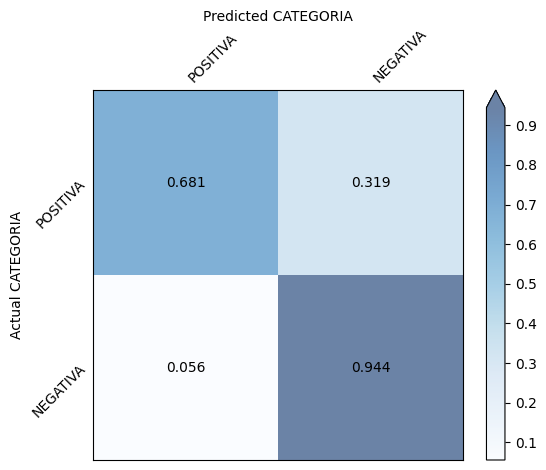

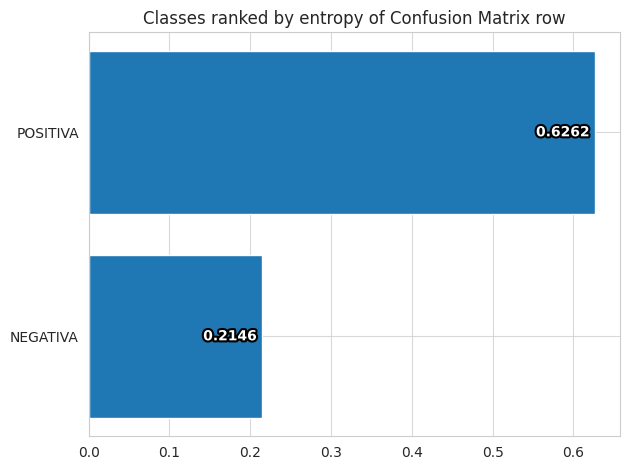

In [ ]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'class',
  top_n_classes=[5],
  model_names=[''],
  normalize=True,
)

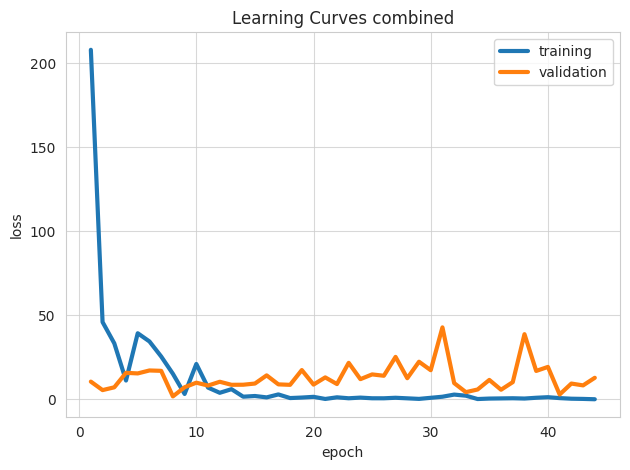

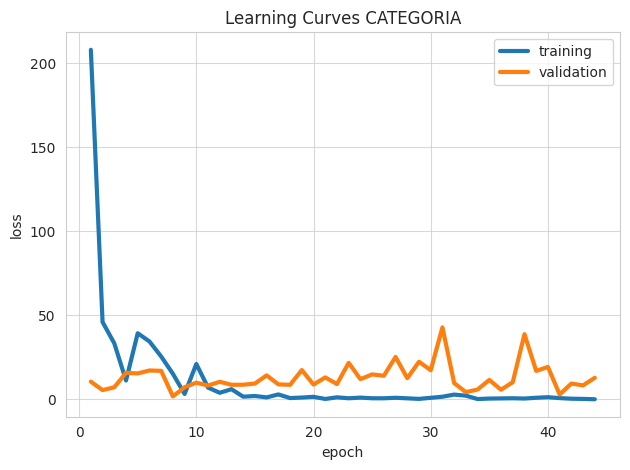

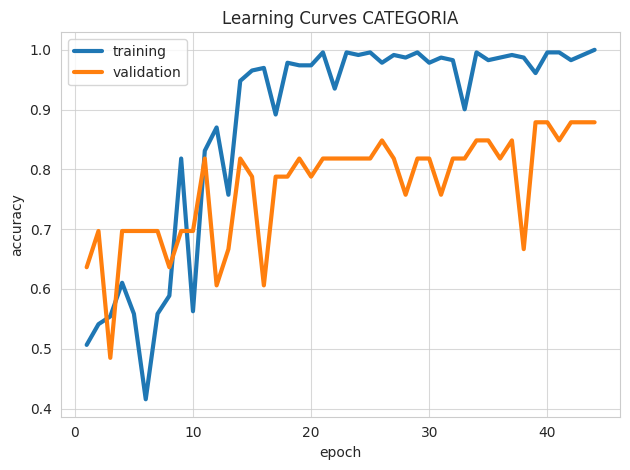

In [ ]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
from ludwig.visualize import learning_curves

learning_curves(train_stats, output_feature_name='class')

In [ ]:
train, valid, test, metadata = pred

In [ ]:
# Evaluación del modelo
evaluation_statistics, predictions, output_directory = model.evaluate(test, collect_overall_stats=True)

Evaluation: 100%|██████████| 5/5 [00:00<00:00,  9.70it/s]

INFO:ludwig.models.predictor:
===== CATEGORIA =====
INFO:ludwig.models.predictor:accuracy: 0.8181818127632141
INFO:ludwig.models.predictor:average_precision_macro: 0.6544666479031804
INFO:ludwig.models.predictor:average_precision_micro: 0.6544666479031804
INFO:ludwig.models.predictor:average_precision_samples: 0.6544666479031804
INFO:ludwig.models.predictor:loss: 10.932673454284668
INFO:ludwig.models.predictor:overall_stats: { 'avg_f1_score_macro': 0.7997977755308392,
  'avg_f1_score_micro': 0.8181818181818182,
  'avg_f1_score_weighted': 0.8255354352422097,
  'avg_precision_macro': 0.7891737891737891,
  'avg_precision_micro': 0.8181818181818182,
  'avg_precision_weighted': 0.8181818181818182,
  'avg_recall_macro': 0.8409854423292273,
  'avg_recall_micro': 0.8181818181818182,
  'avg_recall_weighted': 0.8181818181818182,
  'kappa_score': 0.6059701492537313,
  'token_accuracy': 0.8181818181818182}
INFO:ludwig.models.predictor:per_class_stats: {False: {   'accuracy': 0.8181818181818182,
  

In [ ]:
from ludwig import visualize

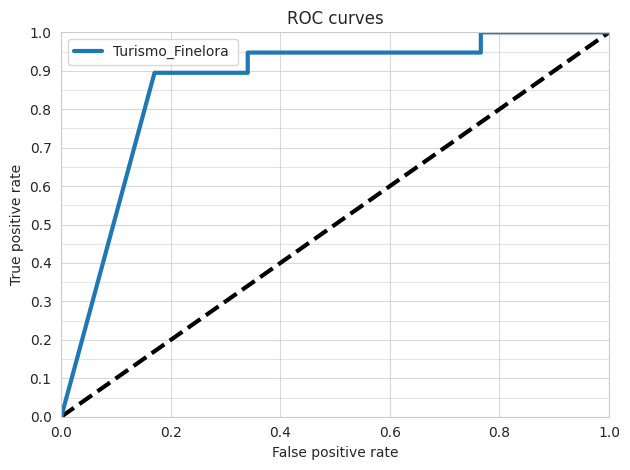

In [ ]:
visualize.roc_curves(
    [predictions['CATEGORIA_probabilities']],
    test.to_df()['CATEGORIA_2Xl8CP'],
    test.to_df(),
    'CATEGORIA_2Xl8CP',
    '1',  # 1 positiva
    model_names=["Turismo_Finelora"],
    output_directory='visualization',
    file_format='png'
)

In [ ]:
from ludwig import visualize

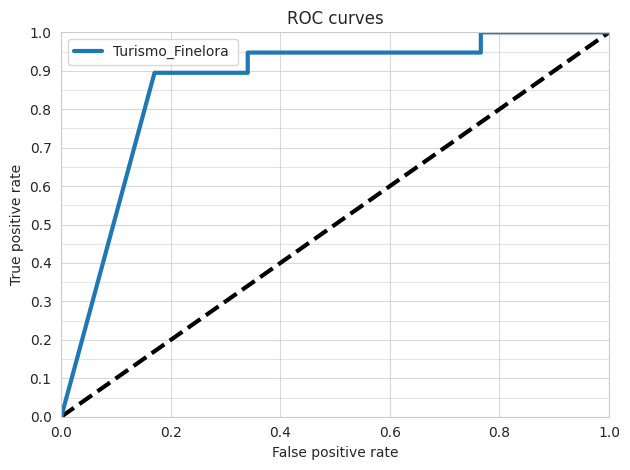

In [ ]:
visualize.roc_curves(
    [predictions['CATEGORIA_probabilities']],
    test.to_df()['CATEGORIA_2Xl8CP'],
    test.to_df(),
    'CATEGORIA_2Xl8CP',
    '-1',  # 1 positiva
    model_names=["Turismo_Finelora"],
    output_directory='visualization',
    file_format='png'
)

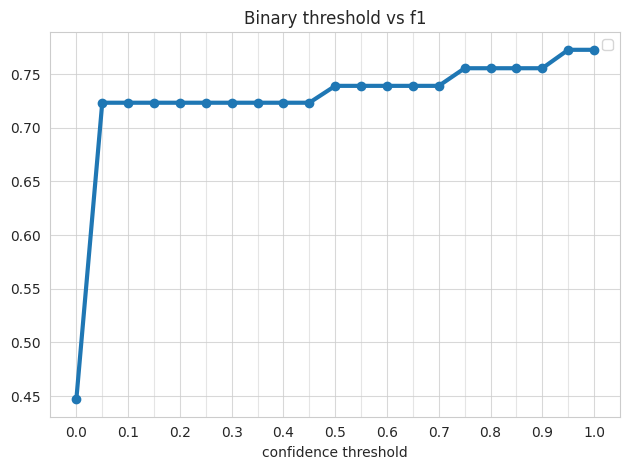

In [ ]:
visualize.binary_threshold_vs_metric(
    [predictions['CATEGORIA_probabilities']],
    test.to_df()['CATEGORIA_2Xl8CP'],
    test.to_df(),
    'CATEGORIA_2Xl8CP',
  ['f1'],# solo hacerlo con F1 para la calibracion
  -1
)

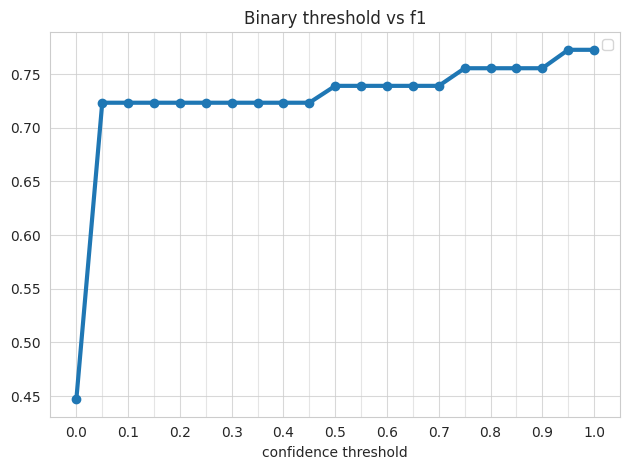

In [ ]:
visualize.binary_threshold_vs_metric(
    [predictions['CATEGORIA_probabilities']],
    test.to_df()['CATEGORIA_2Xl8CP'],
    test.to_df(),
    'CATEGORIA_2Xl8CP',
  ['f1'],# solo hacerlo con F1 para la calibracion
  1
)

In [ ]:
import pandas as pd

# Crear un DataFrame con las descripciones de noticias de turismo
text_to_predict = pd.DataFrame({
    "DESCRIPCION ": [
        "Cartagena celebra un incremento del 20% en turismo gracias a sus festivales de música y arte, impulsando la economía local.",
        "El nuevo parque temático en Medellín atrae a familias de todo el país, marcando un hito en el turismo de aventura urbana.",
        "Colombia es nombrada el mejor destino turístico de Sudamérica por su rica cultura y hospitalidad.",
        "El festival de la flores en Medellín se supera en asistencia, con un aumento del 30% en turistas internacionales.",
        "Escándalo por malas prácticas en hoteles de lujo en Bogotá daña gravemente la imagen turística de la ciudad.",
        "Protestas en varias ciudades importantes afectan negativamente la temporada turística, causando una caída en las reservas.",
        "Informes de inseguridad en Cartagena disuaden a los turistas de visitar, afectando la industria hotelera local.",
        "Desastres naturales en la costa caribeña golpean la industria del turismo, con hoteles y playas cerradas durante meses.",
        "Controversia por la construcción de un nuevo aeropuerto en Barranquilla amenaza zonas ecológicas y despierta críticas de grupos ambientalistas."
    ]
})

# Utilizar el DataFrame para hacer predicciones
predictions, output_directory = model.predict(text_to_predict)

# Ver las predicciones
print(predictions)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded TorchText implementation of distilbert/distilbert-base-multilingual-cased tokenizer


Prediction: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]

INFO:ludwig.api:Finished predicting in: 1.64s.



         CATEGORIA_probabilities CATEGORIA_predictions  \
0   [1.0, 8.586642208378625e-37]              POSITIVA   
1                     [0.0, 1.0]              NEGATIVA   
2  [1.0, 1.0934648709592684e-23]              POSITIVA   
3                     [0.0, 1.0]              NEGATIVA   
4                     [0.0, 1.0]              NEGATIVA   
5                     [0.0, 1.0]              NEGATIVA   
6                     [0.0, 1.0]              NEGATIVA   
7                     [0.0, 1.0]              NEGATIVA   
8                     [0.0, 1.0]              NEGATIVA   

   CATEGORIA_probabilities_POSITIVA  CATEGORIA_probabilities_NEGATIVA  \
0                               1.0                      8.586642e-37   
1                               0.0                      1.000000e+00   
2                               1.0                      1.093465e-23   
3                               0.0                      1.000000e+00   
4                               0.0                  

In [ ]:
#model.save('/content/drive/MyDrive/Tesis/Collabs_finales_Experimentos_nuevo/model')

In [ ]:
model.save_torchscript(
'/content/drive/MyDrive/Tesis/Collabs_finales_Experimentos_nuevo/model',device="cuda")

In [100]:
from ludwig.models.inference import InferenceModule
inference_module=InferenceModule.from_directory('/content/drive/MyDrive/Tesis/Collabs_finales_Experimentos_nuevo/model/')

Loaded torchscript module for preprocessor from inference_preprocessor.pt.
Loaded torchscript module for predictor from inference_predictor-cuda.pt.
Loaded torchscript module for postprocessor from inference_postprocessor.pt.


In [101]:
raw={"DESCRIPCION ":[
    "El nuevo parque temático en Medellín atrae a familias de todo el país, marcando un hito en el turismo de aventura urbana.",

    ]
}

In [102]:
preprocessed_data=inference_module.preprocessor_forward(raw)

In [103]:
predictions=inference_module.predictor_forward(preprocessed_data)


In [104]:
postprocessed_data=inference_module.postprocessor_forward(predictions)

In [105]:
postprocessed_data

{'CATEGORIA': {'predictions': ['NEGATIVA'],
  'probabilities': tensor([[0., 1.]], device='cuda:0')}}

In [39]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 6.3 MB/s eta 0:00:00
  Using cached typer-0.12.3-py3-none-any.whl (47 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.18.2
    Uninstalling pydantic_core-2.18.2:
      Successfully uninstalled pydantic_core-2.18.2
  Attempting uninstall: typer
    Found existing installation: typer 0.9.4
    Uninstalling typer-0.9.4:
      Successfully uninstalled typer-0.9.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.15
    Uninstalling pydantic-1.10.15:
      Successfully uninstalled pydantic-1.10.15
ERROR: pip's dependency resolver does not cu

In [70]:
'la noticia es: '+ postprocessed_data['CATEGORIA']['predictions'][0]

'la noticia es: NEGATIVA'

In [52]:
import gradio as gr

In [77]:

  raw={"DESCRIPCION ":["Noticia"]}
  preprocessed_data=inference_module.preprocessor_forward(raw)
  predictions=inference_module.predictor_forward(preprocessed_data)
  postprocessed_data=inference_module.postprocessor_forward(predictions)



In [106]:
def greet(noticia):
    raw = {"DESCRIPCION ": [noticia]}
    preprocessed_data = inference_module.preprocessor_forward(raw)
    predictions = inference_module.predictor_forward(preprocessed_data)
    postprocessed_data = inference_module.postprocessor_forward(predictions)

    classification = postprocessed_data['CATEGORIA']['predictions'][0]
    return output_label + classification

In [107]:

import gradio as gr



demo = gr.Interface(fn=greet, inputs="textbox", outputs=[gr.Textbox(label="Clasificación")], css="""
   body {background-color : red}
    """,)



if __name__ == "__main__":
    demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://30031a30c4bfb3a8be.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
docker build -t gradio-app:latest

SyntaxError: invalid syntax (<ipython-input-10-5c218ca493bb>, line 1)

In [115]:
from __future__ import annotations
from typing import Iterable
import gradio as gr
from gradio.themes.base import Base
from gradio.themes.utils import colors, fonts, sizes
import time


class Seafoam(Base):
    def __init__(
        self,
        *,
        primary_hue: colors.Color | str = colors.blue,
        secondary_hue: colors.Color | str = colors.red,
        neutral_hue: colors.Color | str = colors.gray,
        spacing_size: sizes.Size | str = sizes.spacing_md,
        radius_size: sizes.Size | str = sizes.radius_md,
        text_size: sizes.Size | str = sizes.text_lg,
        font: fonts.Font
        | str
        | Iterable[fonts.Font | str] = (
            fonts.GoogleFont("Quicksand"),
            "ui-sans-serif",
            "sans-serif",
        ),
        font_mono: fonts.Font
        | str
        | Iterable[fonts.Font | str] = (
            fonts.GoogleFont("IBM Plex Mono"),
            "ui-monospace",
            "monospace",
        ),
    ):
        super().__init__(
            primary_hue=primary_hue,
            secondary_hue=secondary_hue,
            neutral_hue=neutral_hue,
            spacing_size=spacing_size,
            radius_size=radius_size,
            text_size=text_size,
            font=font,
            font_mono=font_mono,
        )
        super().set(
            body_background_fill="repeating-linear-gradient(45deg, *primary_200, *primary_200 10px, *primary_50 10px, *primary_50 20px)",
            body_background_fill_dark="repeating-linear-gradient(45deg, *primary_800, *primary_800 10px, *primary_900 10px, *primary_900 20px)",
            button_primary_background_fill="linear-gradient(90deg, *primary_300, *secondary_400)",
            button_primary_background_fill_hover="linear-gradient(90deg, *primary_200, *secondary_300)",
            button_primary_text_color="white",
            button_primary_background_fill_dark="linear-gradient(90deg, *primary_600, *secondary_800)",
            slider_color="*secondary_300",
            slider_color_dark="*secondary_600",
            block_title_text_weight="600",
            block_border_width="3px",
            block_shadow="*shadow_drop_lg",
            button_shadow="*shadow_drop_lg",
            button_large_padding="32px",
        )



seafoam = Seafoam()

with gr.Blocks(theme=seafoam) as demo:
    textbox = gr.Textbox(label="Noticia")

    with gr.Row():
        button = gr.Button("Submit", variant="primary")
        clear = gr.Button("Clear")
    output = gr.Textbox(label="Clasificación")



if __name__ == "__main__":
    demo.launch()



Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://79086cebd6a37bd900.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
